In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from datetime import datetime

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Deekshitha/Datasets/daily_solar_data.csv')
data = data[(data != -1).all(axis=1)]
data.set_index('Date', inplace=True)
data.index = pd.to_datetime(data.index)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10239 entries, 1997-04-01 to 2024-04-12
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Radio Flux 10.7cm                   10239 non-null  int64 
 1   Sunspot Number                      10239 non-null  int64 
 2   Sunspot Area (10^6 Hemis.)          10239 non-null  int64 
 3   New Regions                         10239 non-null  int64 
 4   Stanford Mean Solar Field (GOES15)  10239 non-null  object
 5   Stanford Background X-Ray Flux      10239 non-null  object
 6   Flares: C                           10239 non-null  int64 
 7   Flares: M                           10239 non-null  int64 
 8   Flares: X                           10239 non-null  int64 
 9   Flares: S                           10239 non-null  int64 
 10  Flares: 1                           10239 non-null  int64 
 11  Flares: 2                           1

In [ ]:
# Extract and scale f10.7 values
f10 = data['Radio Flux 10.7cm'].dropna().values.reshape(-1, 1)
scaler = MinMaxScaler()
f10_scaled = scaler.fit_transform(f10.reshape(-1, 1))

In [ ]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [ ]:
window_size = 12  # Using past 12 months to predict next
X, y = create_sequences(f10_scaled, window_size)

# Reshape for LSTM: [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# ----- Split data -----
split = int(len(X) * 0.9)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# ----- Build LSTM model -----
model = Sequential([
    LSTM(64, activation='tanh', input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# ----- Forecast next 180 months -----
forecast_steps = 120
last_window = f10_scaled[-window_size:].reshape(1, window_size, 1)
forecast_scaled = []
historical_window_for_forecast = list(f10_scaled[-window_size:].flatten()) # Keep track of the evolving window

for _ in range(forecast_steps):
    next_value_scaled = model.predict(np.array(historical_window_for_forecast[-window_size:]).reshape(1, window_size, 1), verbose=0)
    forecast_scaled.append(next_value_scaled[0, 0])
    historical_window_for_forecast.append(next_value_scaled[0, 0]) # Append the prediction to the window

# Inverse scale forecast
forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()

# ----- Generate forecast dates -----
start_date = data.index[-1] + pd.DateOffset(months=1)
forecast_dates = pd.date_range(start=start_date, periods=forecast_steps, freq='MS')

In [ ]:
predicted=pd.read_json('/content/drive/MyDrive/Deekshitha/Datasets/Done_Dusted/predicted-solar-cycle.json')
predicted.head()
predicted['time-tag']=pd.to_datetime(predicted['time-tag'])
predicted.set_index('time-tag',inplace=True)
predicted.head()

,predicted_ssn,high25_ssn,high_ssn,high75_ssn,low25_ssn,low_ssn,low75_ssn,predicted_f10.7,high25_f10.7,high_f10.7,high75_f10.7,low25_f10.7,low_f10.7,low75_f10.7
time-tag,,,,,,,,,,,,,,
2024-10-01,159.2,163.0,167.4,176.1,152.0,146.1,140.1,192.9,195.7,199.1,205.5,187.4,183.0,178.4
2024-11-01,159.7,163.8,169.1,177.8,152.5,146.5,140.2,193.9,197.0,201.0,207.3,188.4,183.9,179.1
2024-12-01,157.3,162.2,168.4,176.9,150.2,144.1,137.5,192.6,196.3,200.9,207.2,187.3,182.6,177.6
2025-01-01,155.5,161.0,168.4,176.6,148.6,142.0,135.3,191.6,195.7,201.2,207.2,186.4,181.4,176.3
2025-02-01,151.0,156.7,164.6,173.5,144.3,137.6,130.7,189.3,193.6,199.5,206.0,184.2,179.2,173.9


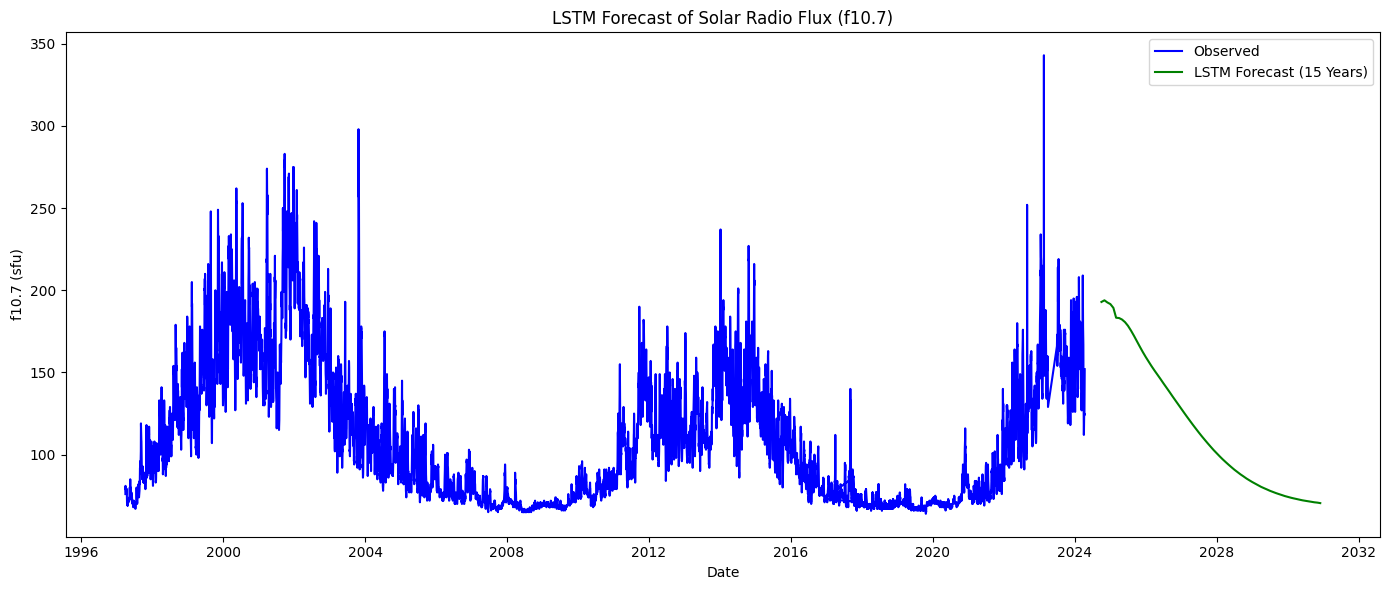

In [ ]:
# ----- Plot the forecast -----
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Radio Flux 10.7cm'], label='Observed', color='blue')
plt.plot(predicted.index, predicted['predicted_f10.7'], label='LSTM Forecast (15 Years)', color='green')
plt.title('LSTM Forecast of Solar Radio Flux (f10.7)')
plt.xlabel('Date')
plt.ylabel('f10.7 (sfu)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# ----- Forecast DataFrame -----
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'f10.7_forecast': forecast
})

# Save if needed
forecast_df.to_csv('f10.7_lstm_forecast_15_years.csv', index=False)

# Show result
forecast_df.head()

In [ ]:
# ----- Create sequences -----
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 60  # Using 5 years of data to predict next value
X, y = create_sequences(f10_scaled, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

# ----- Split data -----
split = int(len(X) * 0.9)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# ----- Build deeper LSTM model -----
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(64),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=150, validation_data=(X_val, y_val), verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# ----- Forecast next 15 years -----
forecast_steps = 180
last_window = f10_scaled[-window_size:].reshape(1, window_size, 1)
forecast_scaled = []

for _ in range(forecast_steps):
    next_value = model.predict(last_window, verbose=0)
    forecast_scaled.append(next_value[0, 0])
    last_window = np.append(last_window[:, 1:, :], next_value.reshape(1, 1, 1), axis=1)

# Inverse scale forecast
forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()

# Generate forecast dates
forecast_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1),
                               periods=forecast_steps, freq='MS')

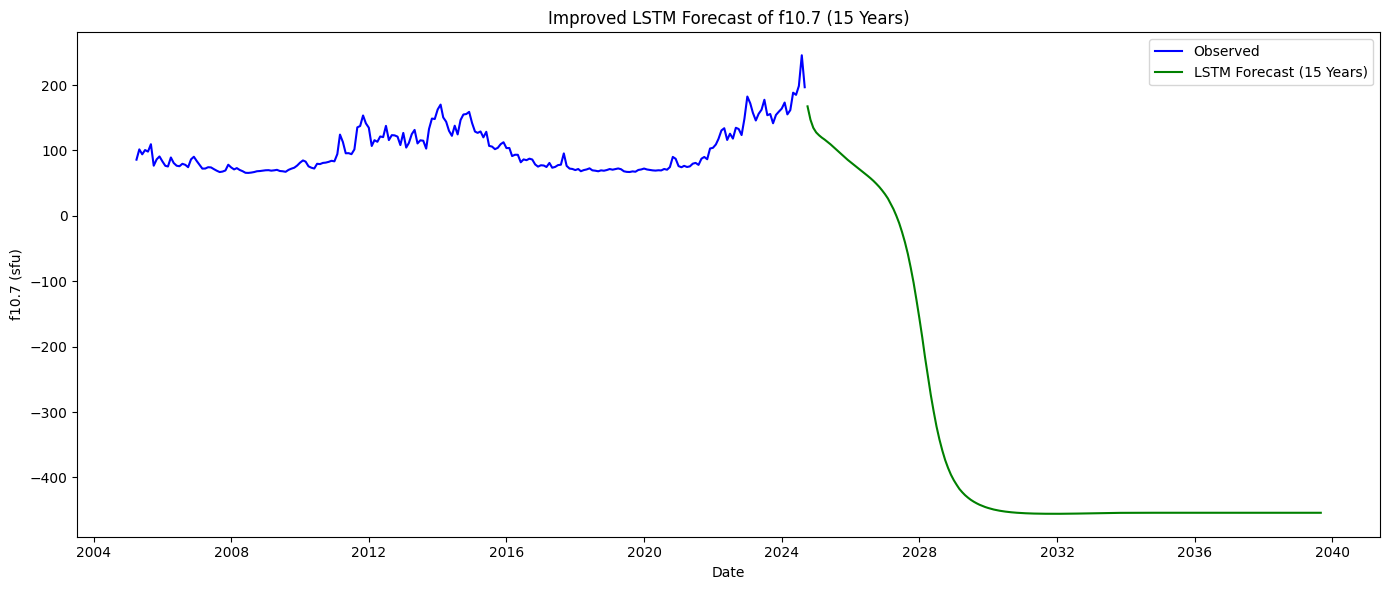

In [ ]:


# ----- Plot -----
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['f10.7'], label='Observed', color='blue')
plt.plot(forecast_dates, forecast, label='LSTM Forecast (15 Years)', color='green')
plt.title('Improved LSTM Forecast of f10.7 (15 Years)')
plt.xlabel('Date')
plt.ylabel('f10.7 (sfu)')
plt.legend()
plt.tight_layout()
plt.show()




In [ ]:
# ----- Output DataFrame -----
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'f10.7_forecast': forecast
})
forecast_df.to_csv('f10.7_lstm_forecast_15_years_improved.csv', index=False)
forecast_df.head()